In [77]:
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

import requests

import PIL
from PIL import Image

In [81]:
transform = transforms.Compose([transforms.Resize((28,28)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [18]:
def img_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

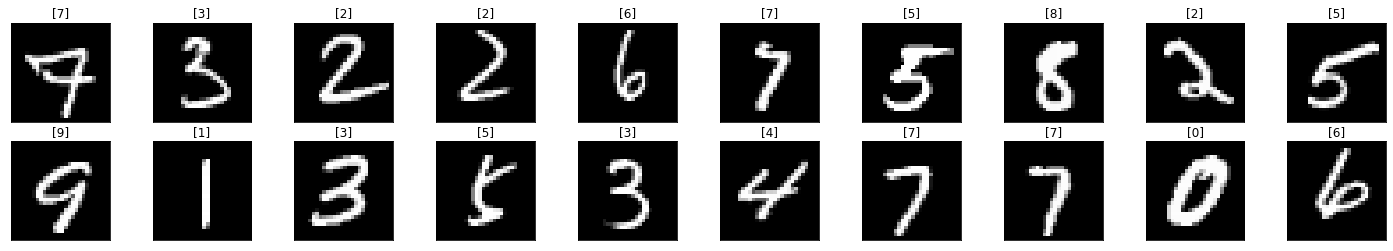

In [19]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [20]:
class Classifier(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super().__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [68]:
def calculate_corrects_and_losses(loader, model, loss_function):
    loss = 0.0
    correct = 0.0
    
    running_loss = 0.0
    running_correct = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.view(inputs.shape[0], -1)
            outputs = model(inputs)
            res = loss_function(outputs, labels)
            running_loss += res.item()

            _, pred_labels = torch.max(outputs, 1)
            running_correct += torch.sum(pred_labels == labels.data)
        
    loss = running_loss / len(loader)
    correct = running_correct.float() / len(loader)
        
    return loss, correct

In [69]:
model = Classifier(784, 125, 65, 10)

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [71]:
epochs = 15
losses = []
corrects = []

val_losses = []
val_corrects = []

for e in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    
    for inputs, labels in training_loader:
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, pred_labels = torch.max(outputs, 1)
        running_correct += torch.sum(pred_labels == labels.data)
        
    epoch_loss = running_loss / len(training_loader)
    losses.append(epoch_loss)
    
    epoch_correct = running_correct.float() / len(training_loader)
    corrects.append(epoch_correct)
    
    print('training loss: {:.4f} corrects: {:.4f}'.format(epoch_loss, epoch_correct))
    
    val_epoch_loss, val_epoch_correct = calculate_corrects_and_losses(validation_loader, model, criterion)
    val_losses.append(val_epoch_loss)
    val_corrects.append(val_epoch_correct)

training loss: 0.4313 corrects: 87.2333
training loss: 0.2095 corrects: 93.7267
training loss: 0.1480 corrects: 95.5733
training loss: 0.1197 corrects: 96.3517
training loss: 0.1002 corrects: 96.8233
training loss: 0.0853 corrects: 97.3250
training loss: 0.0761 corrects: 97.5350
training loss: 0.0710 corrects: 97.8333
training loss: 0.0628 corrects: 97.9750
training loss: 0.0567 corrects: 98.1667
training loss: 0.0524 corrects: 98.3167
training loss: 0.0477 corrects: 98.4217
training loss: 0.0423 corrects: 98.6167
training loss: 0.0414 corrects: 98.6117
training loss: 0.0381 corrects: 98.7133


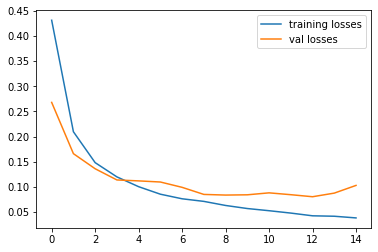

In [72]:
plt.plot(losses, label='training losses')
plt.plot(val_losses, label='val losses')
plt.legend()

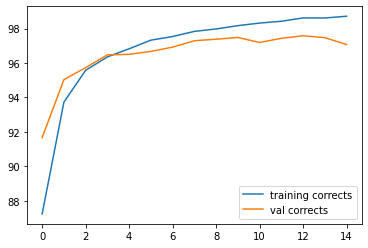

In [73]:
plt.plot(corrects, label='training corrects')
plt.plot(val_corrects, label='val corrects')
plt.legend()

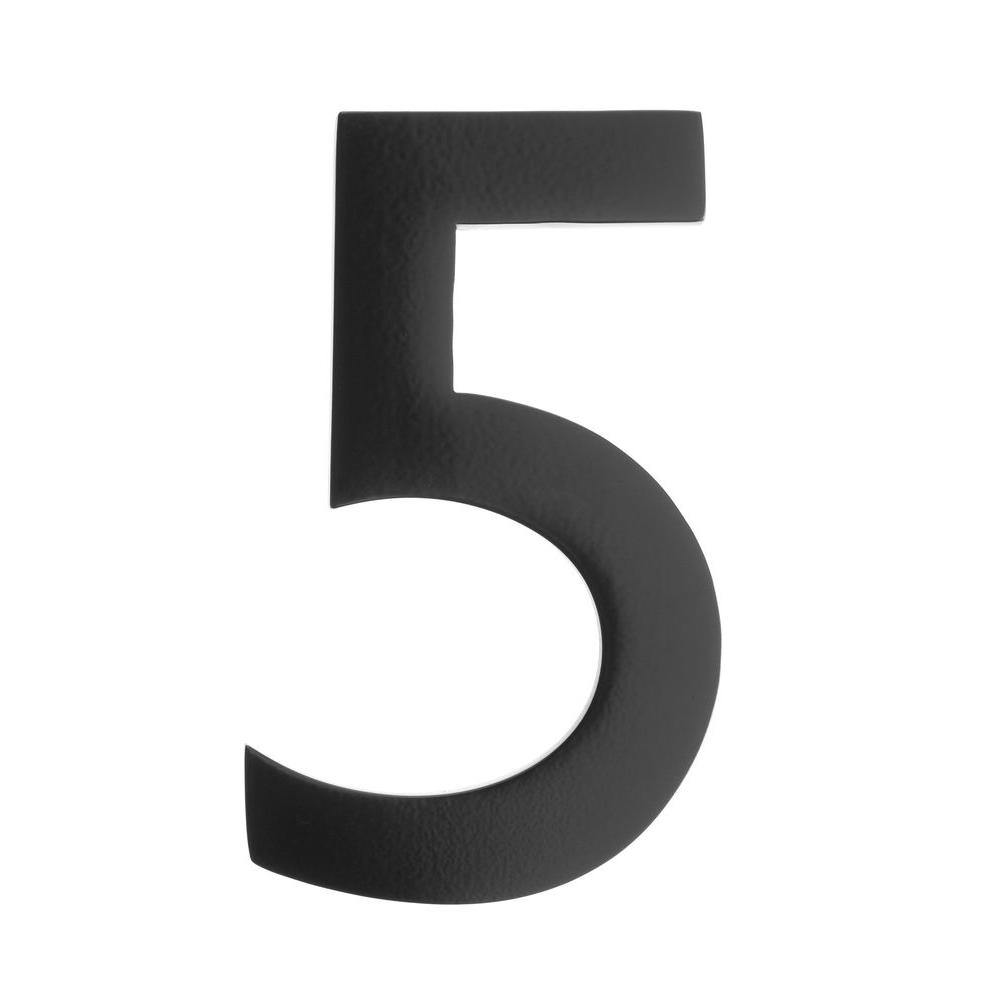

In [88]:
url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
img

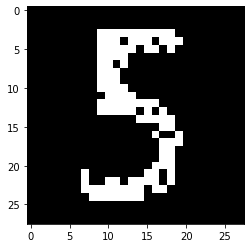

In [89]:
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img)
plt.imshow(img_convert(img))

In [90]:
img = img.view(img.shape[0], -1)
output = model(img)
_, pred_label = torch.max(output, 1)
pred_label

tensor([5])

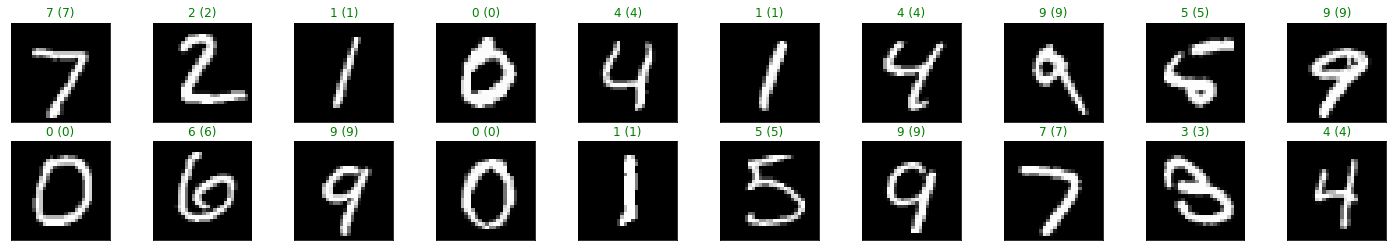

In [102]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

images_ = images.view(images.shape[0], -1)
outputs = model(images_)
_, pred_labels = torch.max(outputs, 1)

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(img_convert(images[idx]))
    ax.set_title("{} ({})".format(pred_labels[idx], labels[idx]), color=("green" if pred_labels[idx] == labels[idx] else "red"))